In [1]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from scipy.stats import norm
import pprint as pp
import yfinance as yf
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

plt.style.use('seaborn')
sns.set_palette('cubehelix')
# plt.style.use('seaborn-colorblind') #alternative
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
#Export stock ticker as list
df = pd.read_csv("ESG 30 stocks.csv", index_col=0)

TICKERS = df['Symbol'].tolist()
TICKERS.sort()
START_DATE = '2017-01-01'
END_DATE = '2022-01-01'

# data1 = data.DataReader(tickers,'yahoo', start_date, end_date)

prices_df = yf.download(TICKERS, start=START_DATE, 
                        end=END_DATE, adjusted=True)

adj_close_df = prices_df['Adj Close']

snp500 = yf.download('^GSPC', start=START_DATE,
                        end=END_DATE, adjusted=True)

snp500_adj_close = snp500['Adj Close']

[*********************100%***********************]  30 of 30 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
N_DAYS=252
N_ASSETS = len(TICKERS)
N_SIMULATION = 10**5

In [4]:
returns_df = adj_close_df.pct_change().dropna()
avg_returns = returns_df.mean() * N_DAYS
cov_mat = returns_df.cov() * N_DAYS

snp500_returns = snp500_adj_close.pct_change().dropna()

In [5]:
#Prepare weights
np.random.seed(0)
weights = np.random.random(size=(N_SIMULATION, N_ASSETS))
weights /=  np.sum(weights, axis=1)[:, np.newaxis]

#Calculate portfolio returns
portf_rtns = np.dot(weights, avg_returns)

#calculate Portfolio beta
merged_portfolio = np.dot(weights,returns_df.T )

portf_beta = []

for candidate in merged_portfolio:
    portf_beta = np.append(portf_beta, np.cov(candidate, snp500_returns)[0][1])

portf_beta = portf_beta / np.var(snp500_returns, ddof=1) 

portf_beta = np.array(portf_beta)

#calculate treynor ratio
treynor_ratio = portf_rtns / portf_beta

#Create a dataframe to store the results
portf_results_df = pd.DataFrame({'returns': portf_rtns,
                                 'beta': portf_beta,
                                 'treynor_ratio': treynor_ratio})

In [6]:
N_POINTS = 100
portf_beta_ef = []
indices_to_skip = []

portf_rtns_ef = np.linspace(portf_results_df.returns.min(), 
                            portf_results_df.returns.max(), 
                            N_POINTS)
portf_rtns_ef = np.round(portf_rtns_ef, 2)    
portf_rtns = np.round(portf_rtns, 2)

for point_index in range(N_POINTS):
    if portf_rtns_ef[point_index] not in portf_rtns:
        indices_to_skip.append(point_index)
        continue
    matched_ind = np.where(portf_rtns == portf_rtns_ef[point_index])
    portf_beta_ef.append(np.min(portf_beta[matched_ind]))
    
portf_rtns_ef = np.delete(portf_rtns_ef, indices_to_skip)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


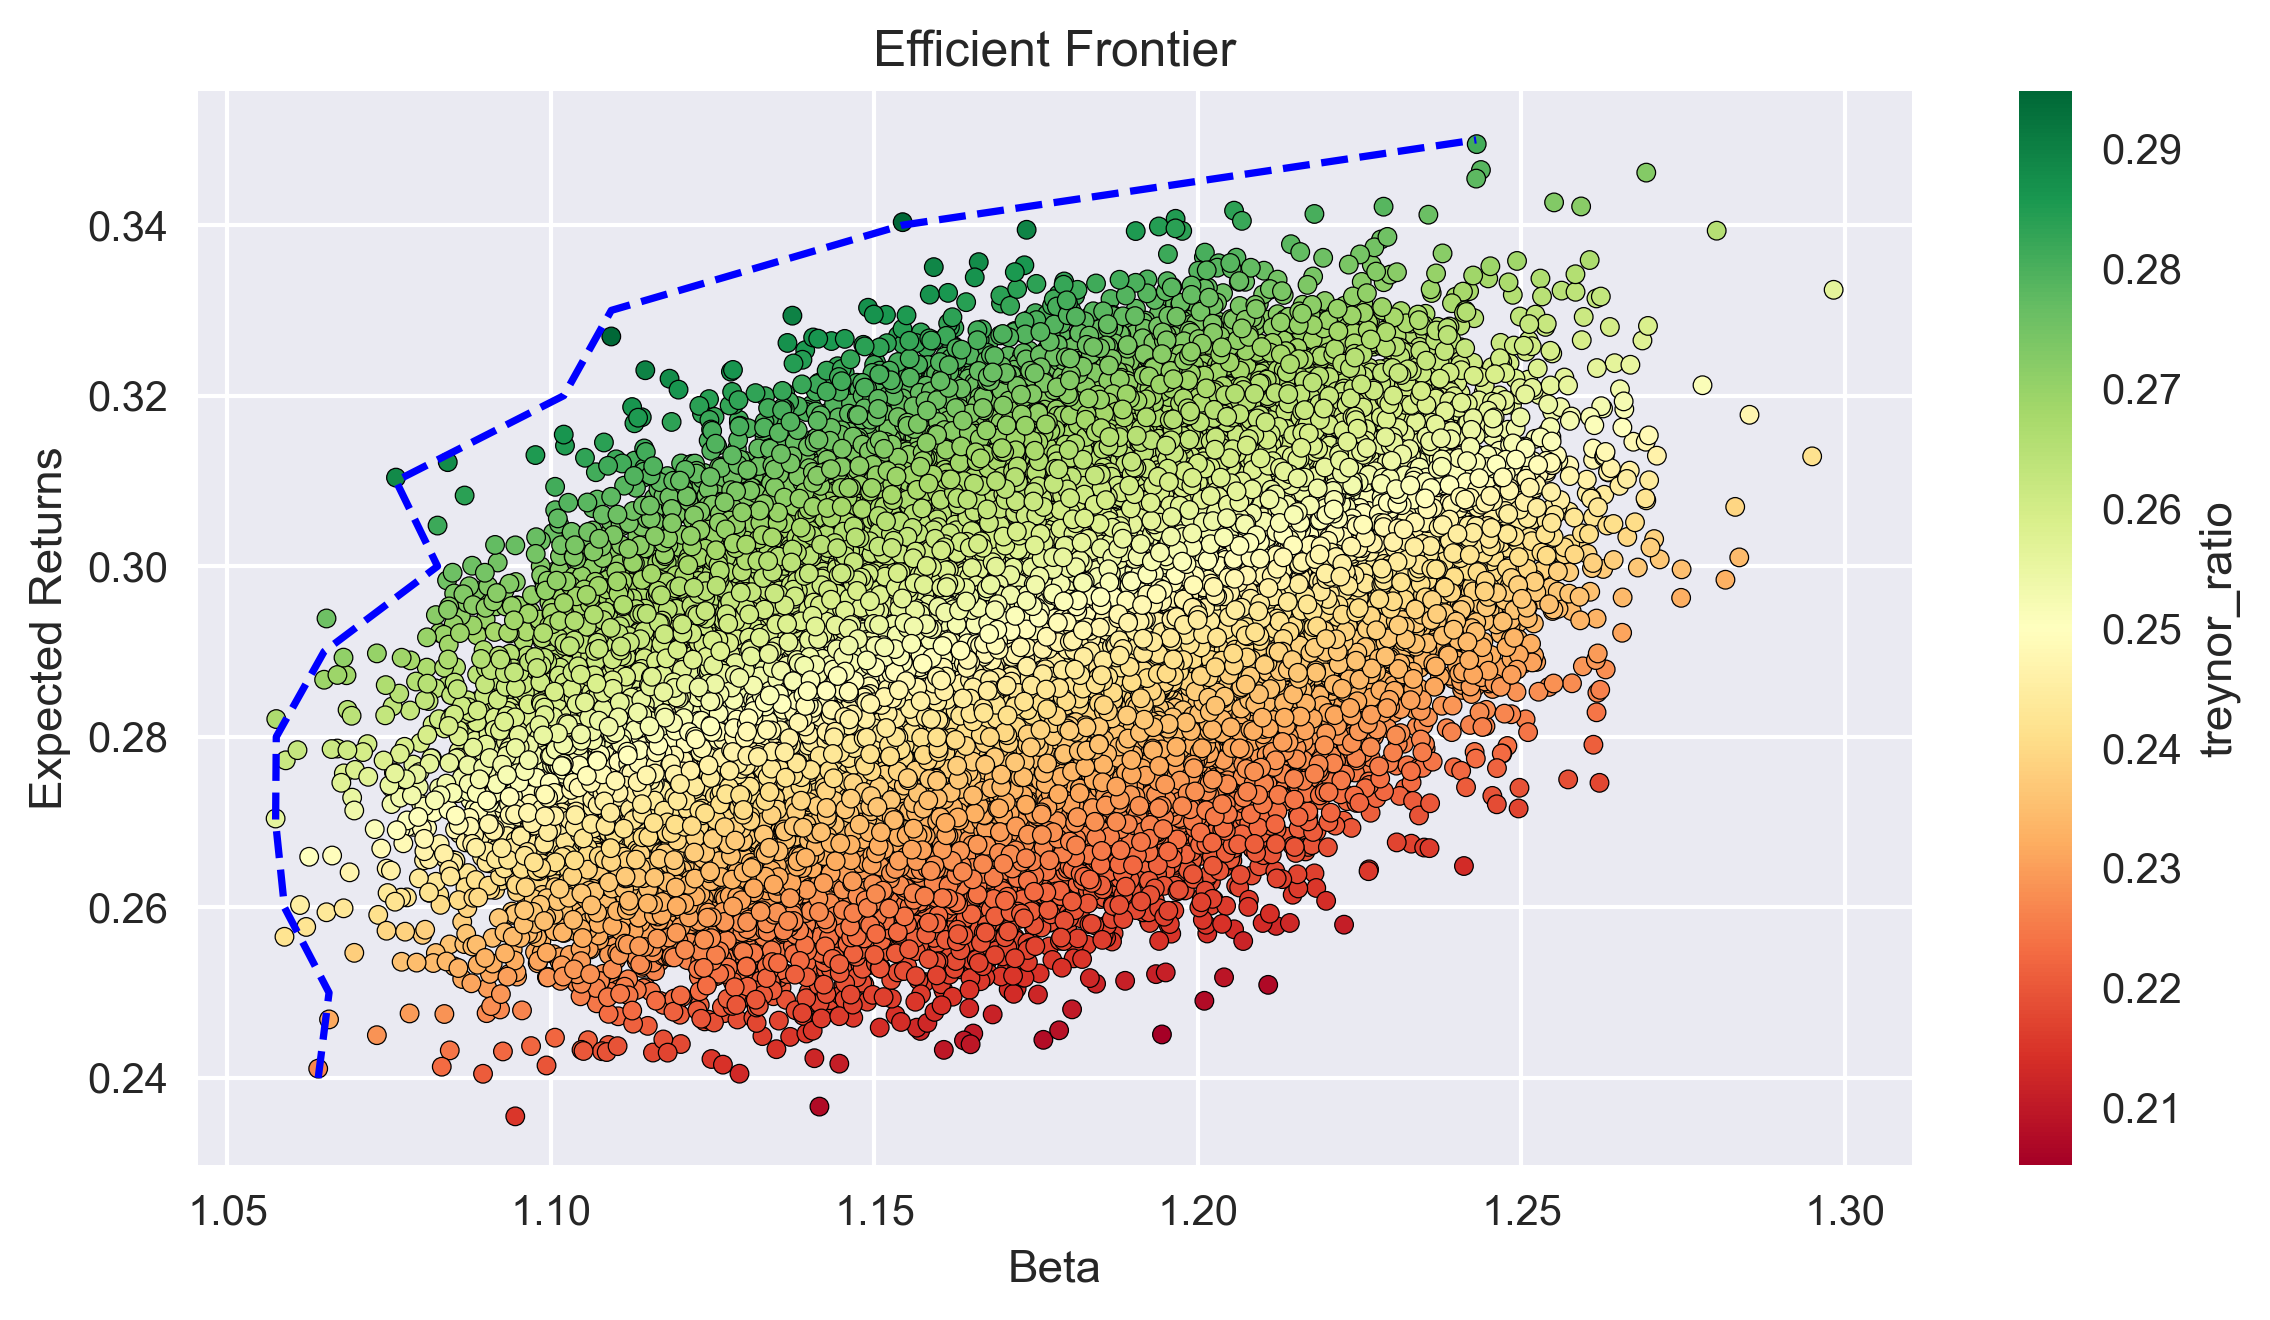

In [7]:
fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='beta', 
                      y='returns', c='treynor_ratio',
                      cmap='RdYlGn', edgecolors='black', 
                      ax=ax)
ax.set(xlabel='Beta', 
       ylabel='Expected Returns', 
       title='Efficient Frontier')
ax.plot(portf_beta_ef, portf_rtns_ef, 'b--')
ax.legend()

plt.tight_layout()
plt.show()

In [8]:
max_treynor_ind = np.argmax(portf_results_df.treynor_ratio)
max_treynor_portf = portf_results_df.loc[max_treynor_ind]

min_beta_ind = np.argmin(portf_results_df.beta)
min_beta_portf = portf_results_df.loc[min_beta_ind]

In [9]:
print('Maximum Treynor Ratio portfolio ----')
print('Performance')
for index, value in max_treynor_portf.items():
    print(f'{index}: {100 * value:.6f}% ', end="", flush=True)
print('\nWeights')
for x, y in zip(TICKERS, weights[np.argmax(portf_results_df.treynor_ratio)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Maximum Treynor Ratio portfolio ----
Performance
returns: 34.034440% beta: 115.436132% treynor_ratio: 29.483351% 
Weights
AAPL: 7.54% ACN: 6.39% AMP: 0.47% AMT: 0.91% ARE: 0.77% ASGN: 1.48% ASIX: 2.66% BCO: 3.83% CBT: 0.12% CC: 2.07% CDNS: 7.74% CRM: 4.13% EBAY: 6.63% FIVE: 7.22% FN: 3.11% FR: 2.99% FTNT: 7.61% HOLX: 6.21% JBHT: 0.43% KIM: 1.57% MATX: 4.19% MHK: 0.10% NKE: 1.12% NVDA: 6.68% ON: 1.39% SPG: 4.50% STM: 0.56% TEL: 2.12% WDAY: 3.62% WM: 1.82% 

In [10]:
print('Minimum Beta portfolio ----')
print('Performance')
for index, value in min_beta_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights')
for x, y in zip(TICKERS, weights[np.argmin(portf_results_df.beta)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Minimum Beta portfolio ----
Performance
returns: 27.04% beta: 105.74% treynor_ratio: 25.57% 
Weights
AAPL: 3.53% ACN: 5.32% AMP: 1.35% AMT: 1.57% ARE: 6.59% ASGN: 1.30% ASIX: 4.77% BCO: 4.07% CBT: 2.30% CC: 0.05% CDNS: 0.34% CRM: 0.61% EBAY: 6.46% FIVE: 0.71% FN: 5.95% FR: 3.80% FTNT: 6.06% HOLX: 6.98% JBHT: 6.84% KIM: 0.99% MATX: 4.68% MHK: 4.07% NKE: 2.00% NVDA: 0.80% ON: 0.58% SPG: 0.76% STM: 5.73% TEL: 4.44% WDAY: 0.54% WM: 6.81% 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


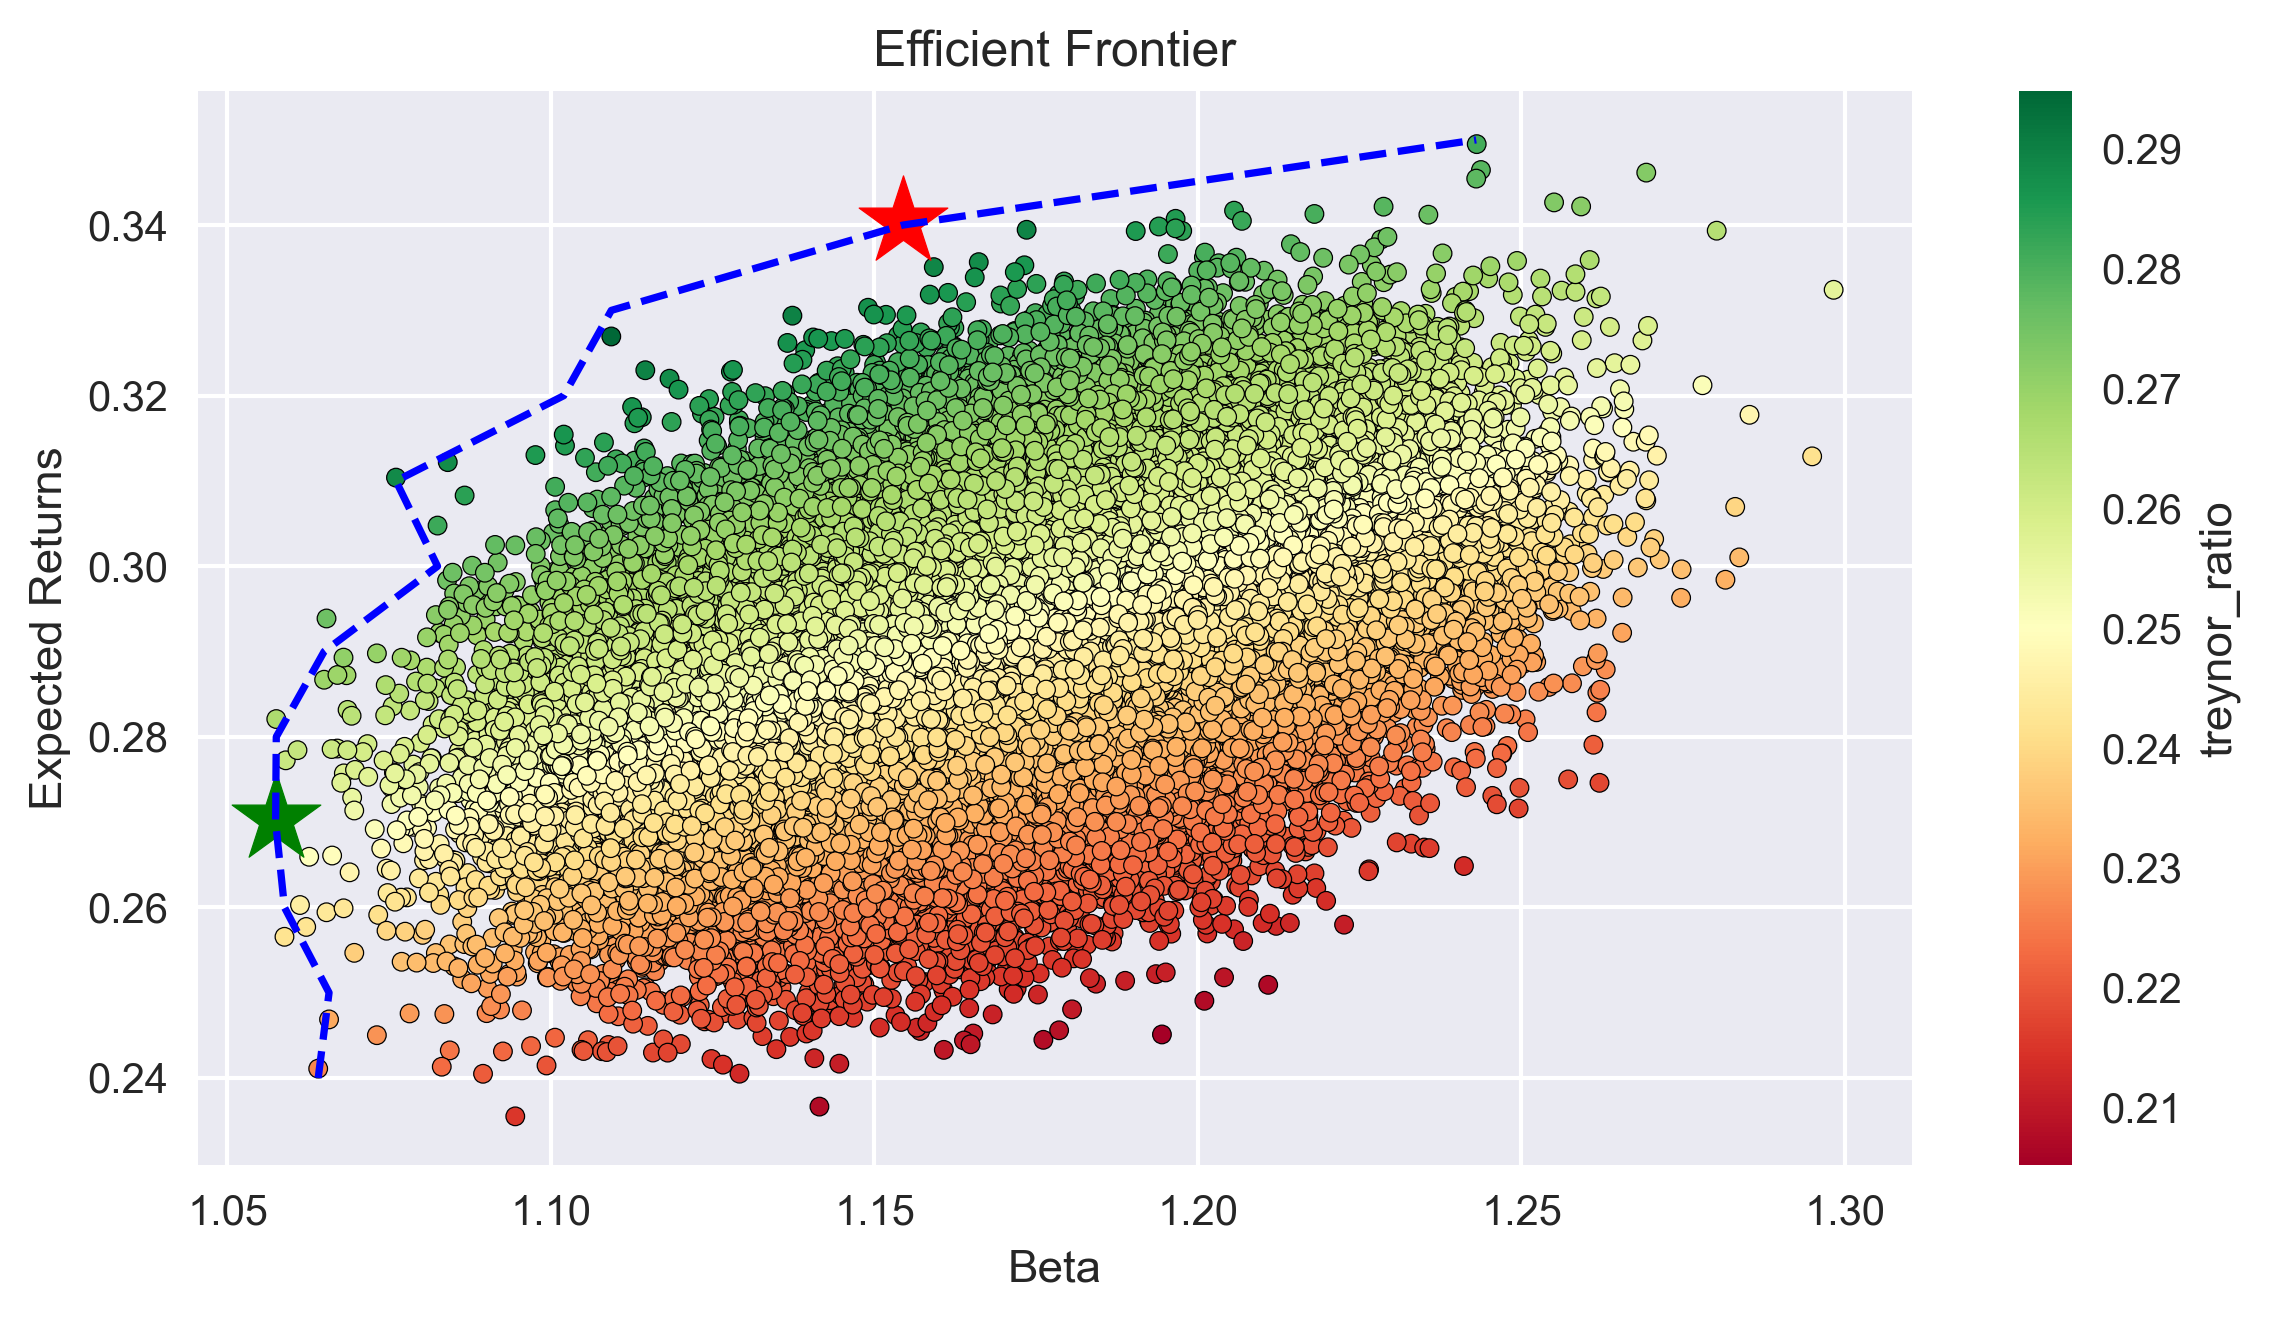

In [11]:
#Create scatter plot coloured by Sharpe Ratio
fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='beta',
                        y='returns', c='treynor_ratio',
                        cmap='RdYlGn', edgecolors='black',
                        ax=ax)

ax.set(xlabel='Beta',
        ylabel='Expected Returns',
        title='Efficient Frontier')
ax.plot(portf_beta_ef, portf_rtns_ef, 'b--')
ax.legend()

#plot red star to highlight position of portfolio with highest Sharpe Ratio
ax.scatter(x=max_treynor_portf.beta, y=max_treynor_portf.returns,
                c='red', marker='*', s=500)

#plot green star to highlight position of minimum variance portfolio
ax.scatter(x=min_beta_portf.beta, y=min_beta_portf.returns,
                c='green', marker='*', s=500)

plt.tight_layout()
plt.show()




In [12]:
import scipy.optimize as sco

In [13]:
def get_portf_rtn(w, avg_rtns):
    return np.sum(avg_rtns * w)

# def get_portf_vol(w, avg_rtns, cov_mat):
#     return np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))

def get_portf_beta(w, avg_rtns, rtns_df, snp500_rtns):
    #calculate Portfolio beta
    merged_portfolio = np.dot(w,rtns_df.T )
    portf_beta = np.cov(merged_portfolio, snp500_rtns)[0][1]/np.var(snp500_rtns, ddof=1) 

    return portf_beta

def get_efficient_frontier(avg_rtns, returns_df, snp500_returns, rtns_range):
    
    efficient_portfolios = []
    
    n_assets = len(avg_rtns)
    args = (avg_rtns, returns_df, snp500_returns)
    bounds = tuple((0,1) for asset in range(n_assets))
    initial_guess = n_assets * [1. / n_assets, ]
    
    for ret in rtns_range:
        constraints = ({'type': 'eq', 
                        'fun': lambda x: get_portf_rtn(x, avg_rtns) - ret},
                       {'type': 'eq', 
                        'fun': lambda x: np.sum(x) - 1})
        efficient_portfolio = sco.minimize(get_portf_beta, initial_guess, 
                                           args=args, method='SLSQP', 
                                           constraints=constraints,
                                           bounds=bounds)
        efficient_portfolios.append(efficient_portfolio)
    
    return efficient_portfolios

In [14]:
rtns_range = np.linspace(0.2, 0.58, 200)

efficient_portfolios = get_efficient_frontier(avg_returns, 
                                              returns_df,
                                              snp500_returns, 
                                              rtns_range)

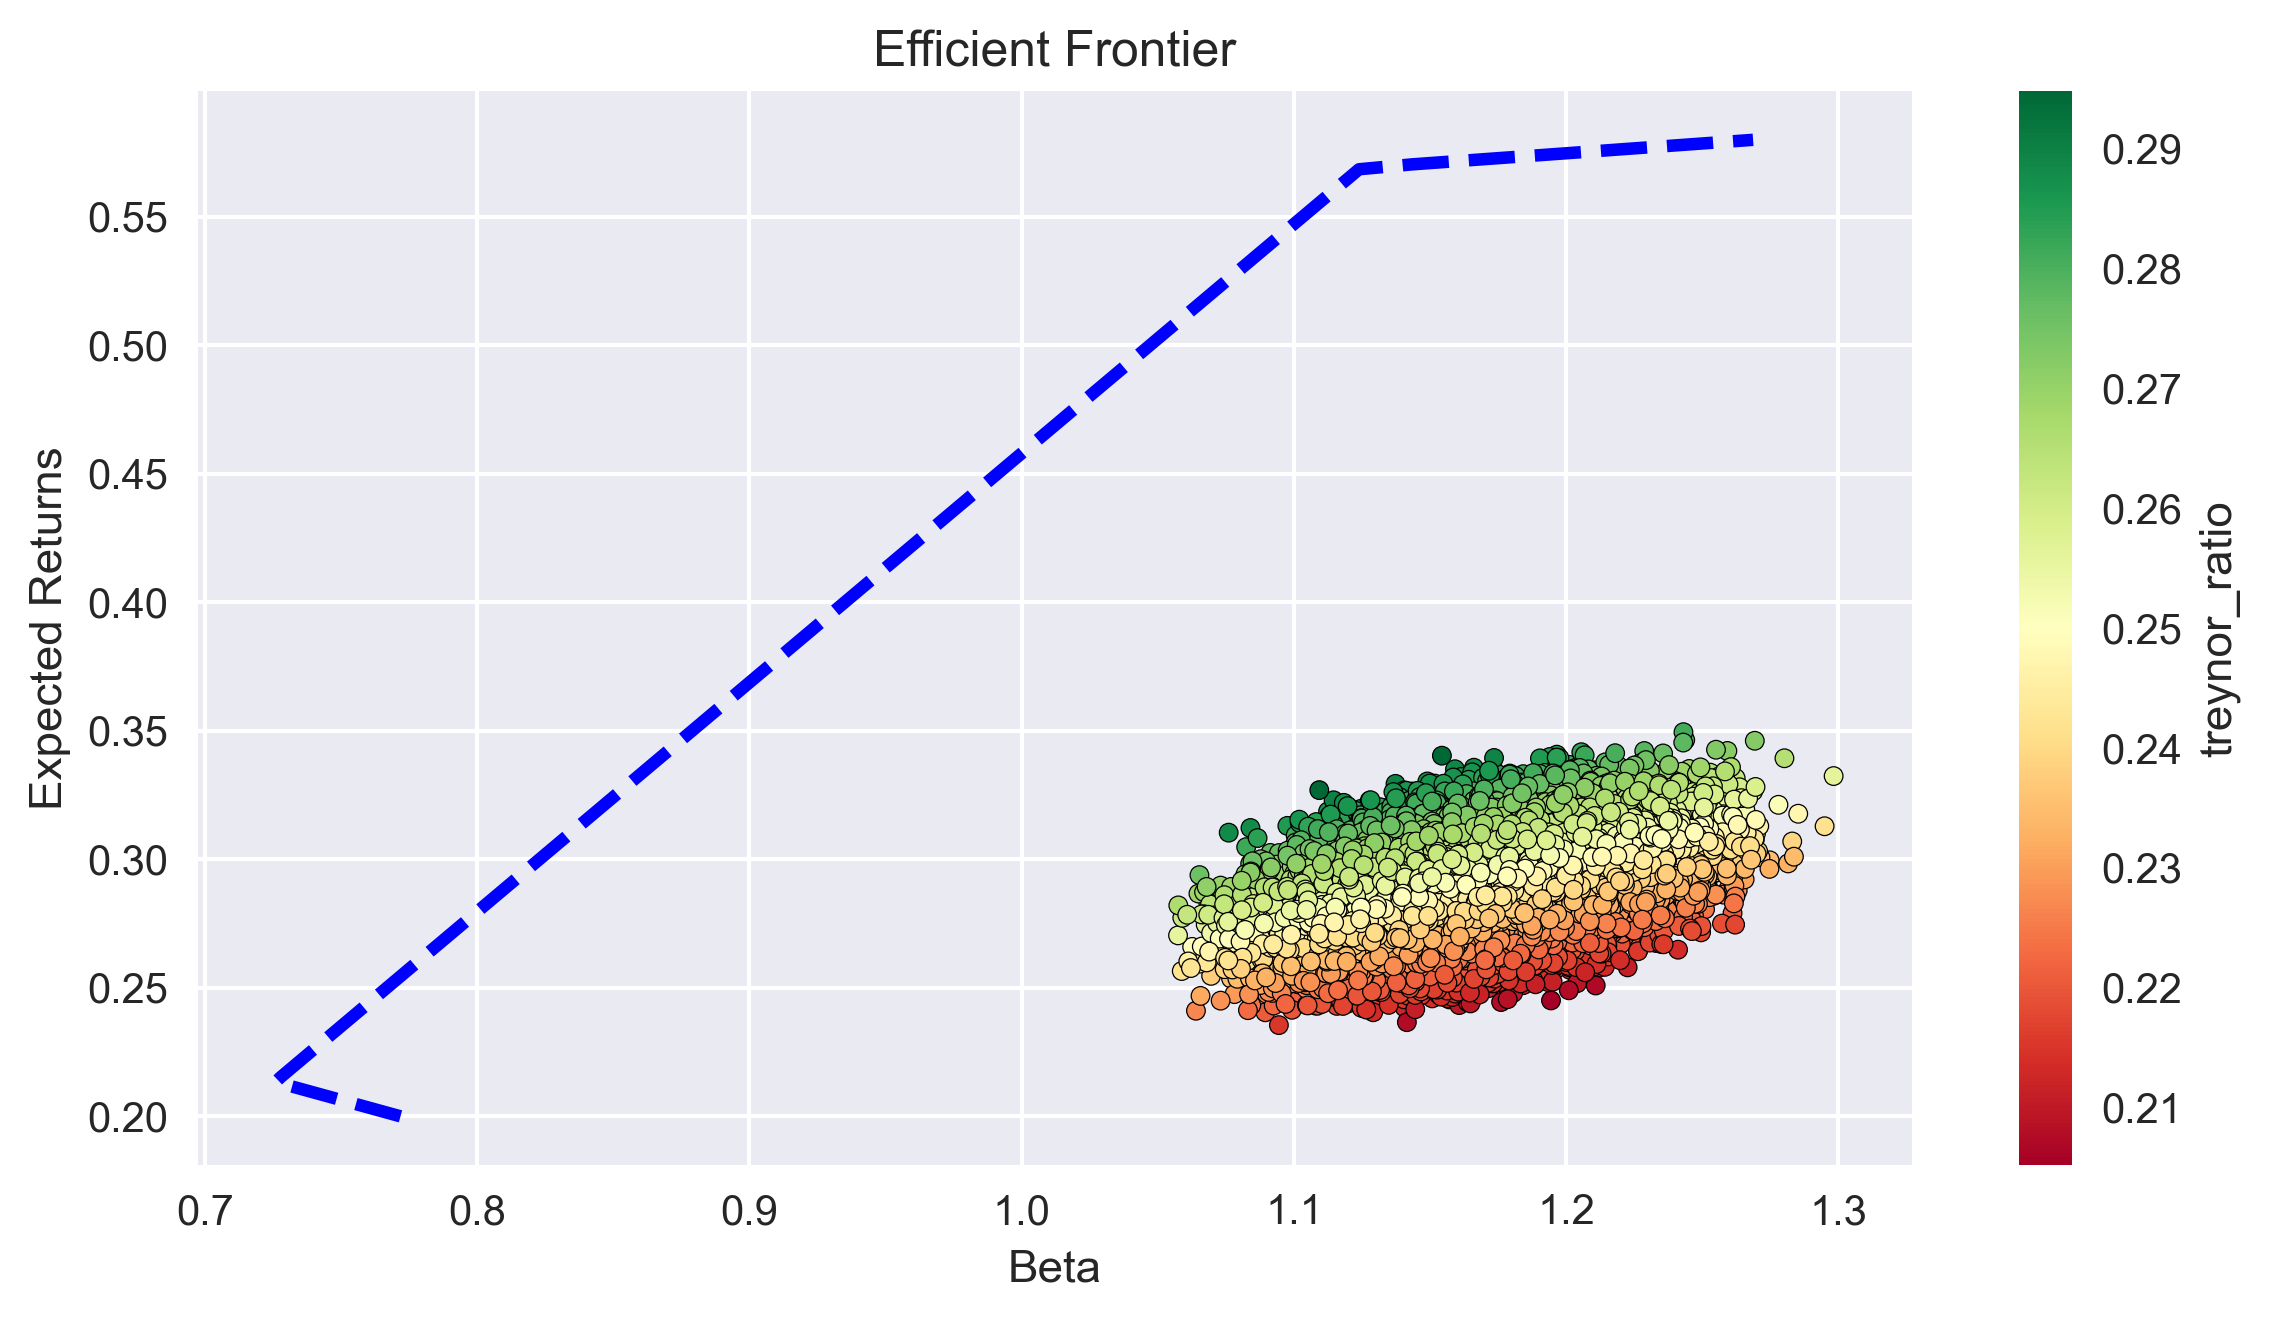

In [15]:
beta_range = [x['fun'] for x in efficient_portfolios]
fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='beta', 
                      y='returns', c='treynor_ratio',
                      cmap='RdYlGn', edgecolors='black', 
                      ax=ax)
ax.plot(beta_range, rtns_range, 'b--', linewidth=3)
ax.set(xlabel='Beta', 
       ylabel='Expected Returns', 
       title='Efficient Frontier')

plt.tight_layout()
# plt.savefig('images/ch7_im12.png')
plt.show()

In [16]:
min_beta_ind = np.argmin(beta_range)
min_beta_portf_rtn = rtns_range[min_beta_ind]
min_beta_portf_beta = efficient_portfolios[min_beta_ind]['fun']

min_beta_portf = {'Return': min_beta_portf_rtn,
                 'Beta': min_beta_portf_beta,
                 'Treynor Ratio': (min_beta_portf_rtn / 
                                  min_beta_portf_beta)}
                                
print('Minimum Beta portfolio ----')
print('Performance')

for index, value in min_beta_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)

portfolio2={}
print('\nWeights')
for x, y in zip(TICKERS, efficient_portfolios[min_beta_ind]['x']):
    # if y < 0.000001:
    #     continue
    portfolio2[x]=y
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Minimum Beta portfolio ----
Performance
Return: 21.34% Beta: 72.60% Treynor Ratio: 29.39% 
Weights
AAPL: 0.00% ACN: 0.00% AMP: 0.00% AMT: 0.00% ARE: 0.00% ASGN: 0.00% ASIX: 0.00% BCO: 0.00% CBT: 0.00% CC: 0.00% CDNS: 0.00% CRM: 0.00% EBAY: 0.00% FIVE: 0.00% FN: 0.00% FR: 0.00% FTNT: 0.00% HOLX: 0.00% JBHT: 0.00% KIM: 0.00% MATX: 0.00% MHK: 0.04% NKE: 0.00% NVDA: 0.00% ON: 0.00% SPG: 0.00% STM: 0.00% TEL: 0.00% WDAY: 0.00% WM: 99.96% 

In [17]:
# import csv
# with open('Portfolio 2.csv', 'w') as f:
#     for key in portfolio2.keys():
#         f.write("%s,%s\n"%(key,portfolio2[key]))

# import pandas as pd
# df = pd.read_csv('Portfolio 2.csv', header=None)
# df.columns = ['Asset', 'Weight']
# df.to_csv('Portfolio 2.csv', index=False)
# df.to_excel('Portfolio 2.xlsx', index=False)

In [18]:

def neg_treynor_ratio(w, avg_rtns, rtns_df, snp500_rtns,RF_RATE):
    portf_returns = np.sum(avg_rtns * w)
    merged_portfolio = np.dot(w,rtns_df.T )
    portf_beta = np.cov(merged_portfolio, snp500_rtns)[0][1]/np.var(snp500_rtns, ddof=1) 
    portf_treynor_ratio = (portf_returns-RF_RATE) / portf_beta

    return -portf_treynor_ratio

RF_RATE = 0

args = (avg_returns, returns_df, snp500_returns,RF_RATE)
constraints = ({'type': 'eq', 
                'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0,1) for asset in range(N_ASSETS))
initial_guess = N_ASSETS * [1. / N_ASSETS]

max_treynor_portf = sco.minimize(neg_treynor_ratio, 
                                x0=initial_guess, 
                                args=args,
                                method='SLSQP', 
                                bounds=bounds, 
                                constraints=constraints)

In [19]:
max_treynor_portf_w = max_treynor_portf['x']
max_treynor_portf = {'Return': get_portf_rtn(max_treynor_portf_w, 
                                            avg_returns),
                    'Beta': get_portf_beta(max_treynor_portf_w, 
                                                avg_returns, 
                                                returns_df,
                                                snp500_returns),
                    'Treynor Ratio': -max_treynor_portf['fun']}

print('Maximum Treynor Ratio portfolio ----')
print('Performance')

for index, value in max_treynor_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)

print('\nWeights')
portfolio1 = {}
for x, y in zip(TICKERS, max_treynor_portf_w):
    # if y < 0.000001:
    #     continue
    portfolio1[x]=y
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)
    

Maximum Treynor Ratio portfolio ----
Performance
Return: 56.90% Beta: 112.44% Treynor Ratio: 50.60% 
Weights
AAPL: 0.00% ACN: 0.00% AMP: 0.00% AMT: 0.00% ARE: 0.00% ASGN: 0.00% ASIX: 0.00% BCO: 0.00% CBT: 0.00% CC: 0.00% CDNS: 0.00% CRM: 0.00% EBAY: 0.00% FIVE: 0.00% FN: 0.00% FR: 0.00% FTNT: 100.00% HOLX: 0.00% JBHT: 0.00% KIM: 0.00% MATX: 0.00% MHK: 0.00% NKE: 0.00% NVDA: 0.00% ON: 0.00% SPG: 0.00% STM: 0.00% TEL: 0.00% WDAY: 0.00% WM: 0.00% 

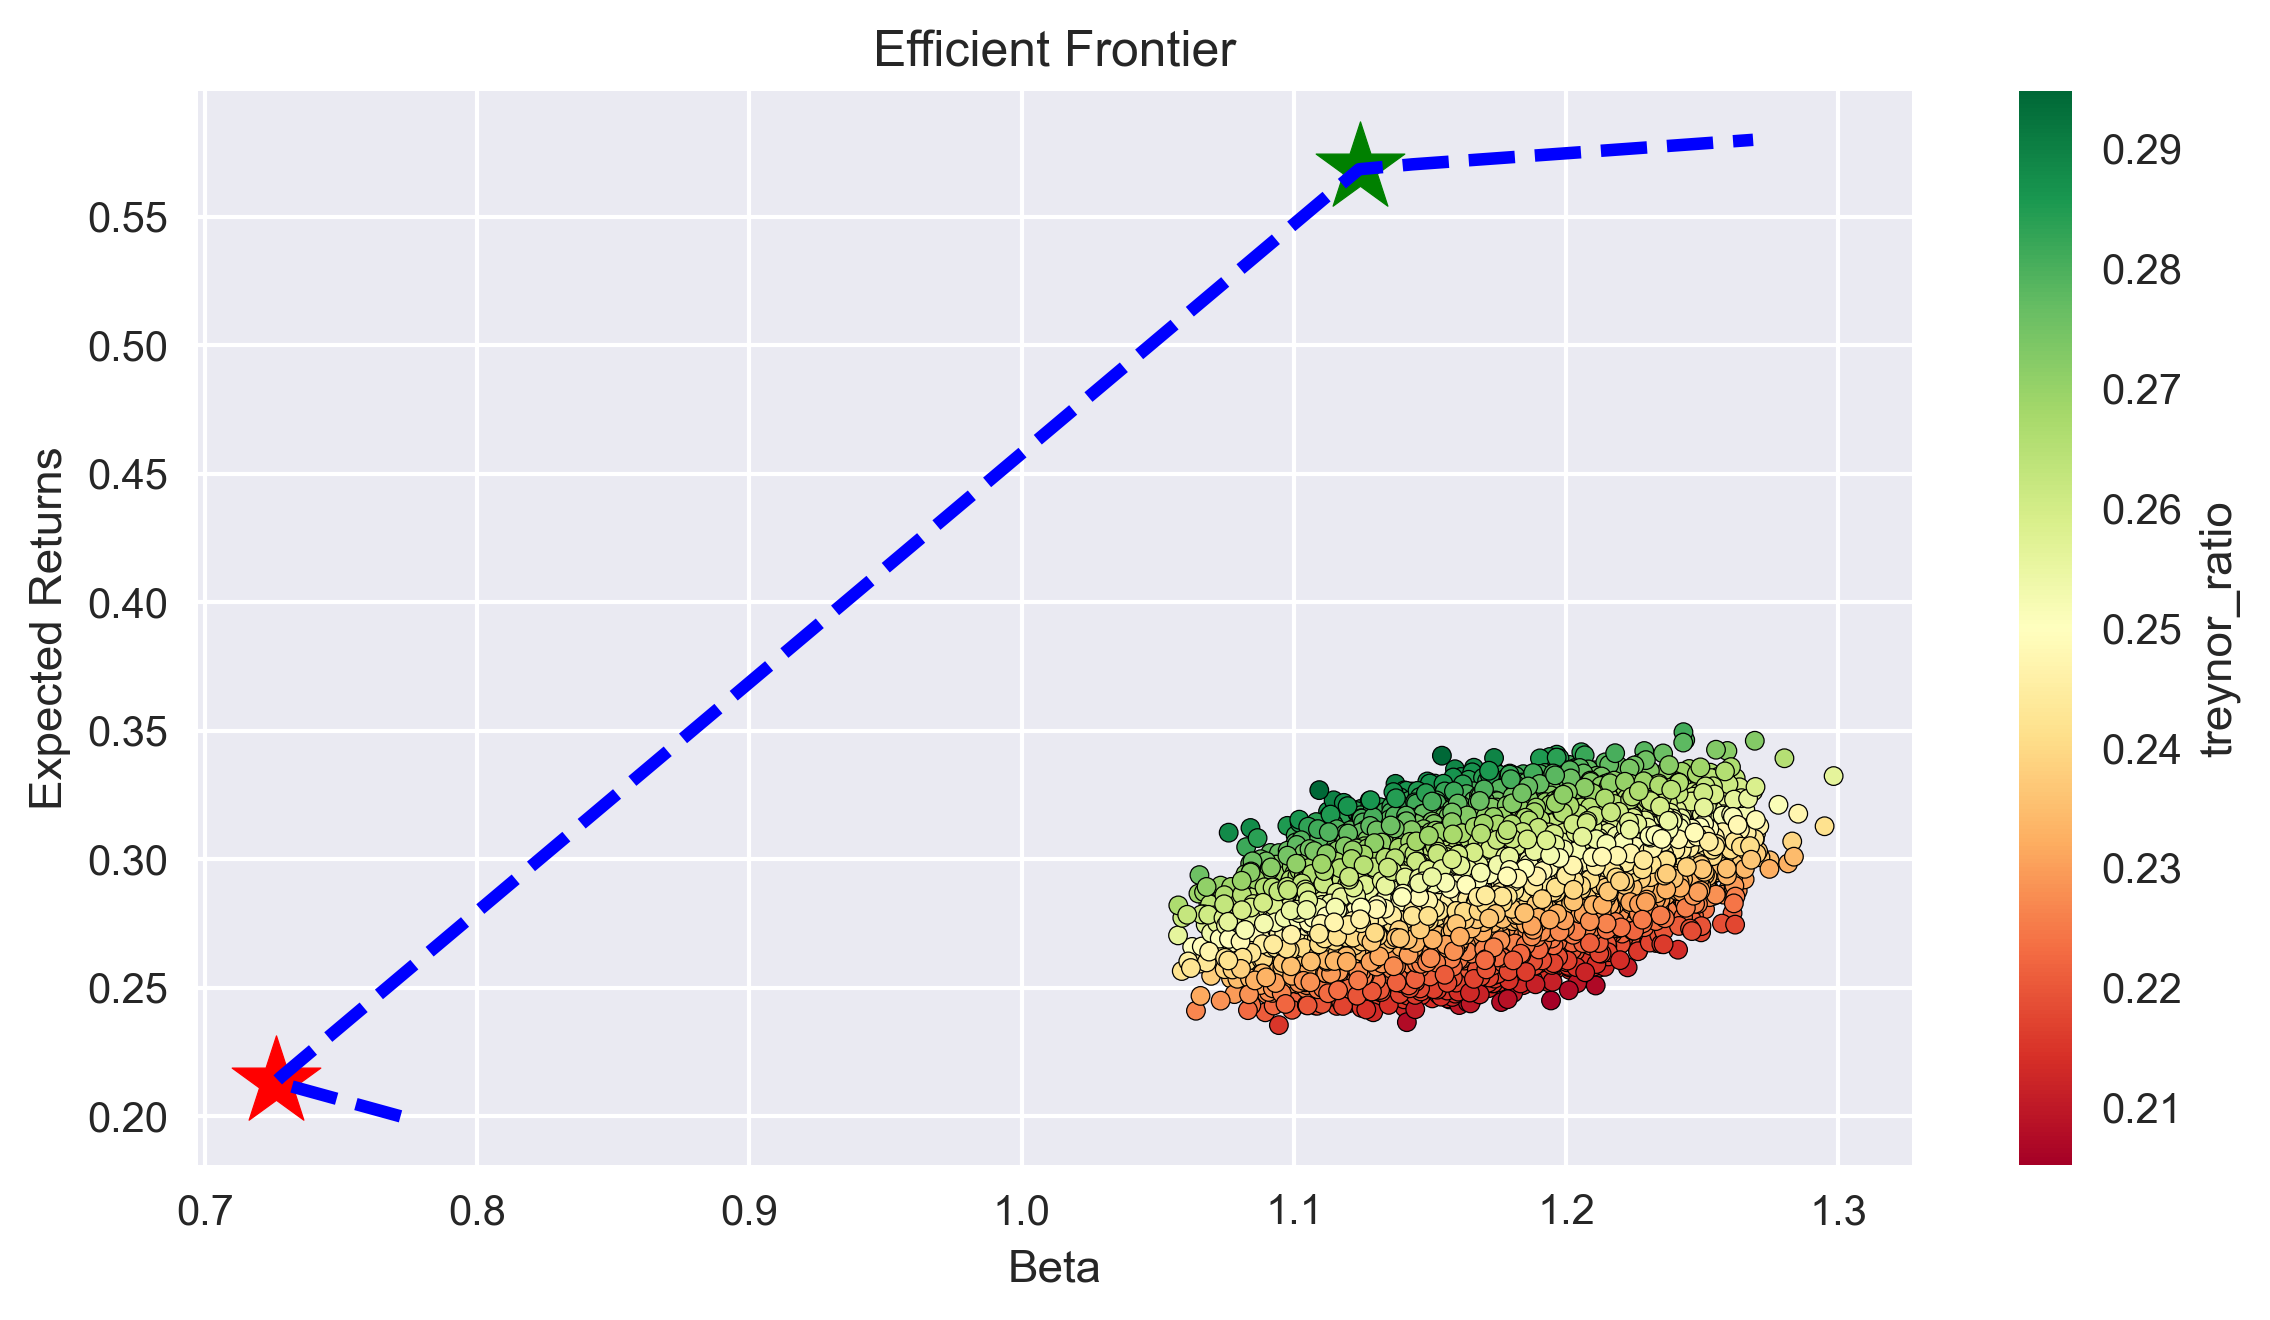

In [20]:
fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='beta', 
                      y='returns', c='treynor_ratio',
                      cmap='RdYlGn', edgecolors='black', 
                      ax=ax)
ax.plot(beta_range, rtns_range, 'b--', linewidth=3)
ax.set(xlabel='Beta', 
       ylabel='Expected Returns', 
       title='Efficient Frontier')

#plot red star to highlight position of portfolio with highest Sharpe Ratio
ax.scatter(x=max_treynor_portf['Beta'], y=max_treynor_portf['Return'],
                c='green', marker='*', s=500)

#plot green star to highlight position of minimum variance portfolio
ax.scatter(x=min_beta_portf['Beta'], y=min_beta_portf['Return'],
                c='red', marker='*', s=500)


plt.tight_layout()
# plt.savefig('images/ch7_im8.png')
plt.show()

In [21]:
# import csv
# with open('Portfolio 1.csv', 'w') as f:
#     for key in portfolio1.keys():
#         f.write("%s,%s\n"%(key,portfolio1[key]))

# import pandas as pd
# df = pd.read_csv('Portfolio 1.csv', header=None)
# df.columns = ['Asset', 'Weight']
# df.to_csv('Portfolio 1.csv', index=False)
# df.to_excel('Portfolio 1.xlsx', index=False)

In [22]:
import pyfolio as pf
x = adj_close_df.pct_change().dropna()
y = max_treynor_portf_w
# y = efficient_portfolios[min_vol_ind]['x']
# y = min_beta_portf_w
z = x * y
c = z.sum(axis = 1)


c:\Users\juans\anaconda3\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [23]:
#calculate beta against S&P 500
sp500_df = yf.download('^GSPC', start=START_DATE,
                       end=END_DATE, adjusted=True)
sp500_df = sp500_df['Adj Close'].pct_change().dropna()

#create a dataframe with the portfolio and S&P 500
beta_portfolio_df = pd.DataFrame({'Portfolio': c,
                                    'S&P 500': sp500_df})

#calculate correlation
corr = beta_portfolio_df.corr().iloc[0,1]
print(f'Correlation: {corr:.2f}')


# #calculate beta
covar = beta_portfolio_df.cov().iloc[0,1]
varSnP = beta_portfolio_df['S&P 500'].var()
beta = covar / varSnP

print(f'Beta: {beta:.2f}')




[*********************100%***********************]  1 of 1 completed
Correlation: 0.57
Beta: 1.12


In [24]:
sharpe_portfolio3 = ((c.mean() - 0)/ c.std())*np.sqrt(252)
print("*****Sharpe Ratio of Portfolio3**** :\n", sharpe_portfolio3.round(2))

*****Sharpe Ratio of Portfolio3**** :
 1.49


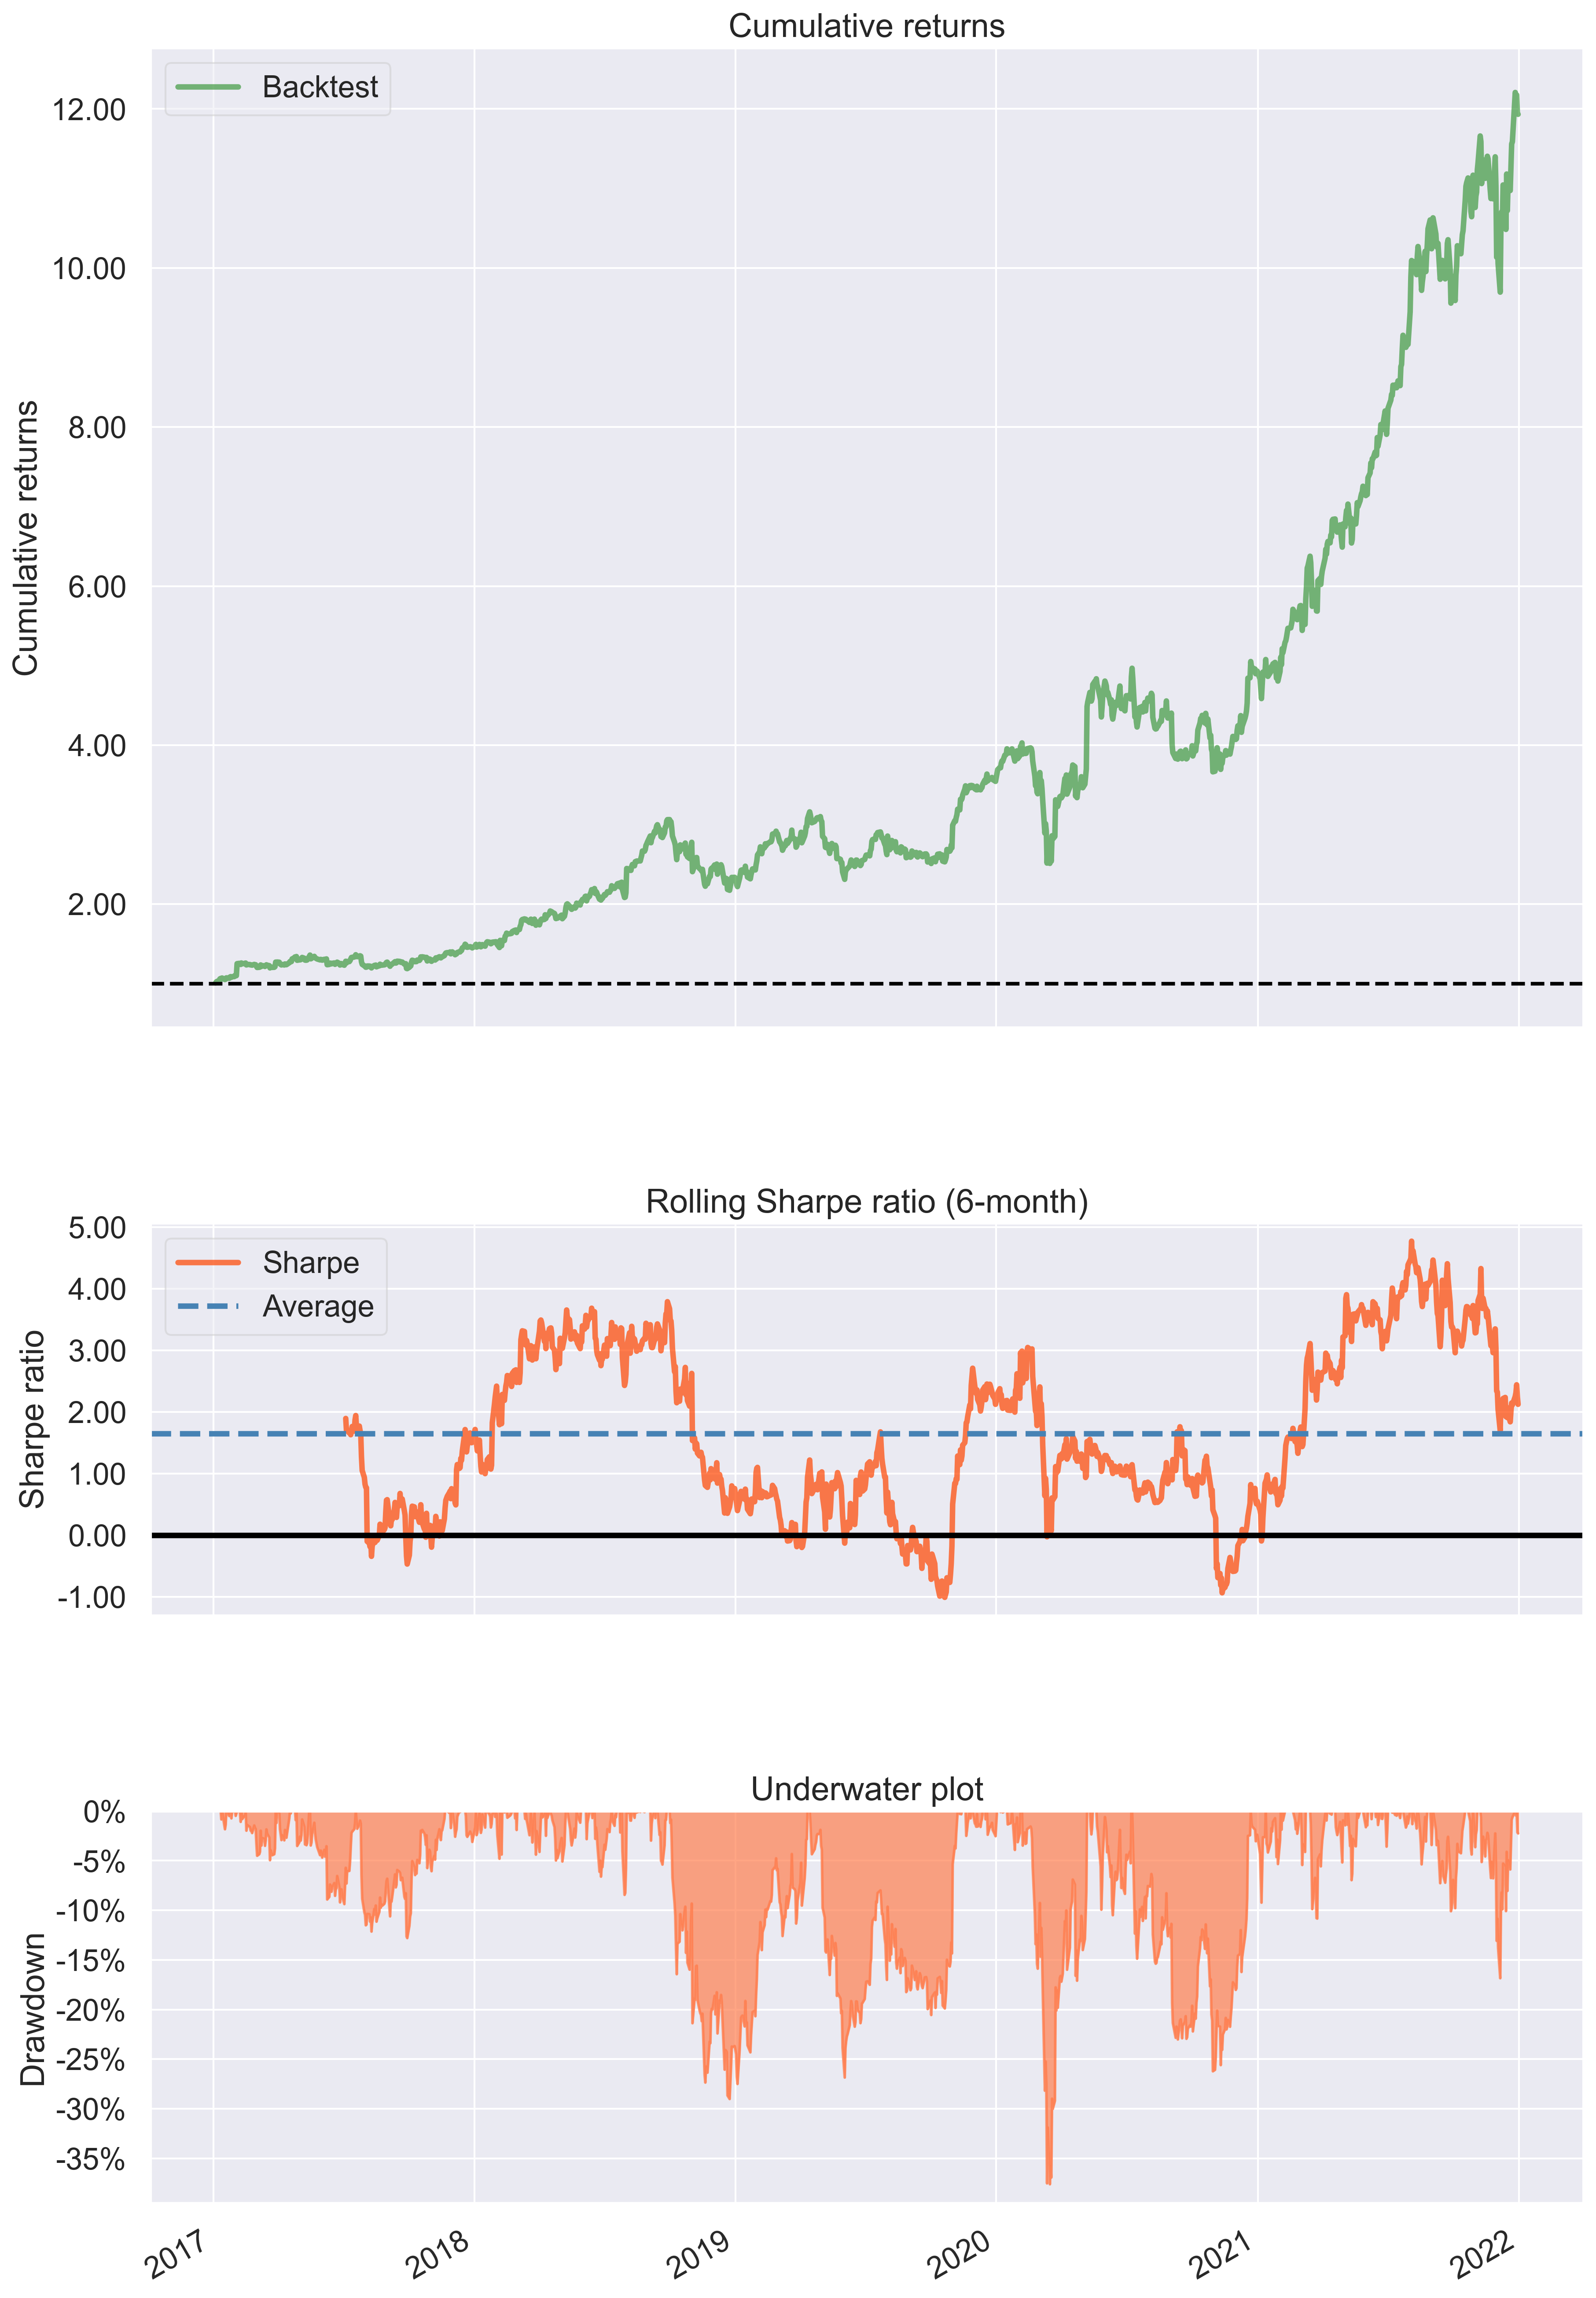

In [25]:
#plot the returns
# portfolio_returns_pyfolio.plot()

pf.create_simple_tear_sheet(c)

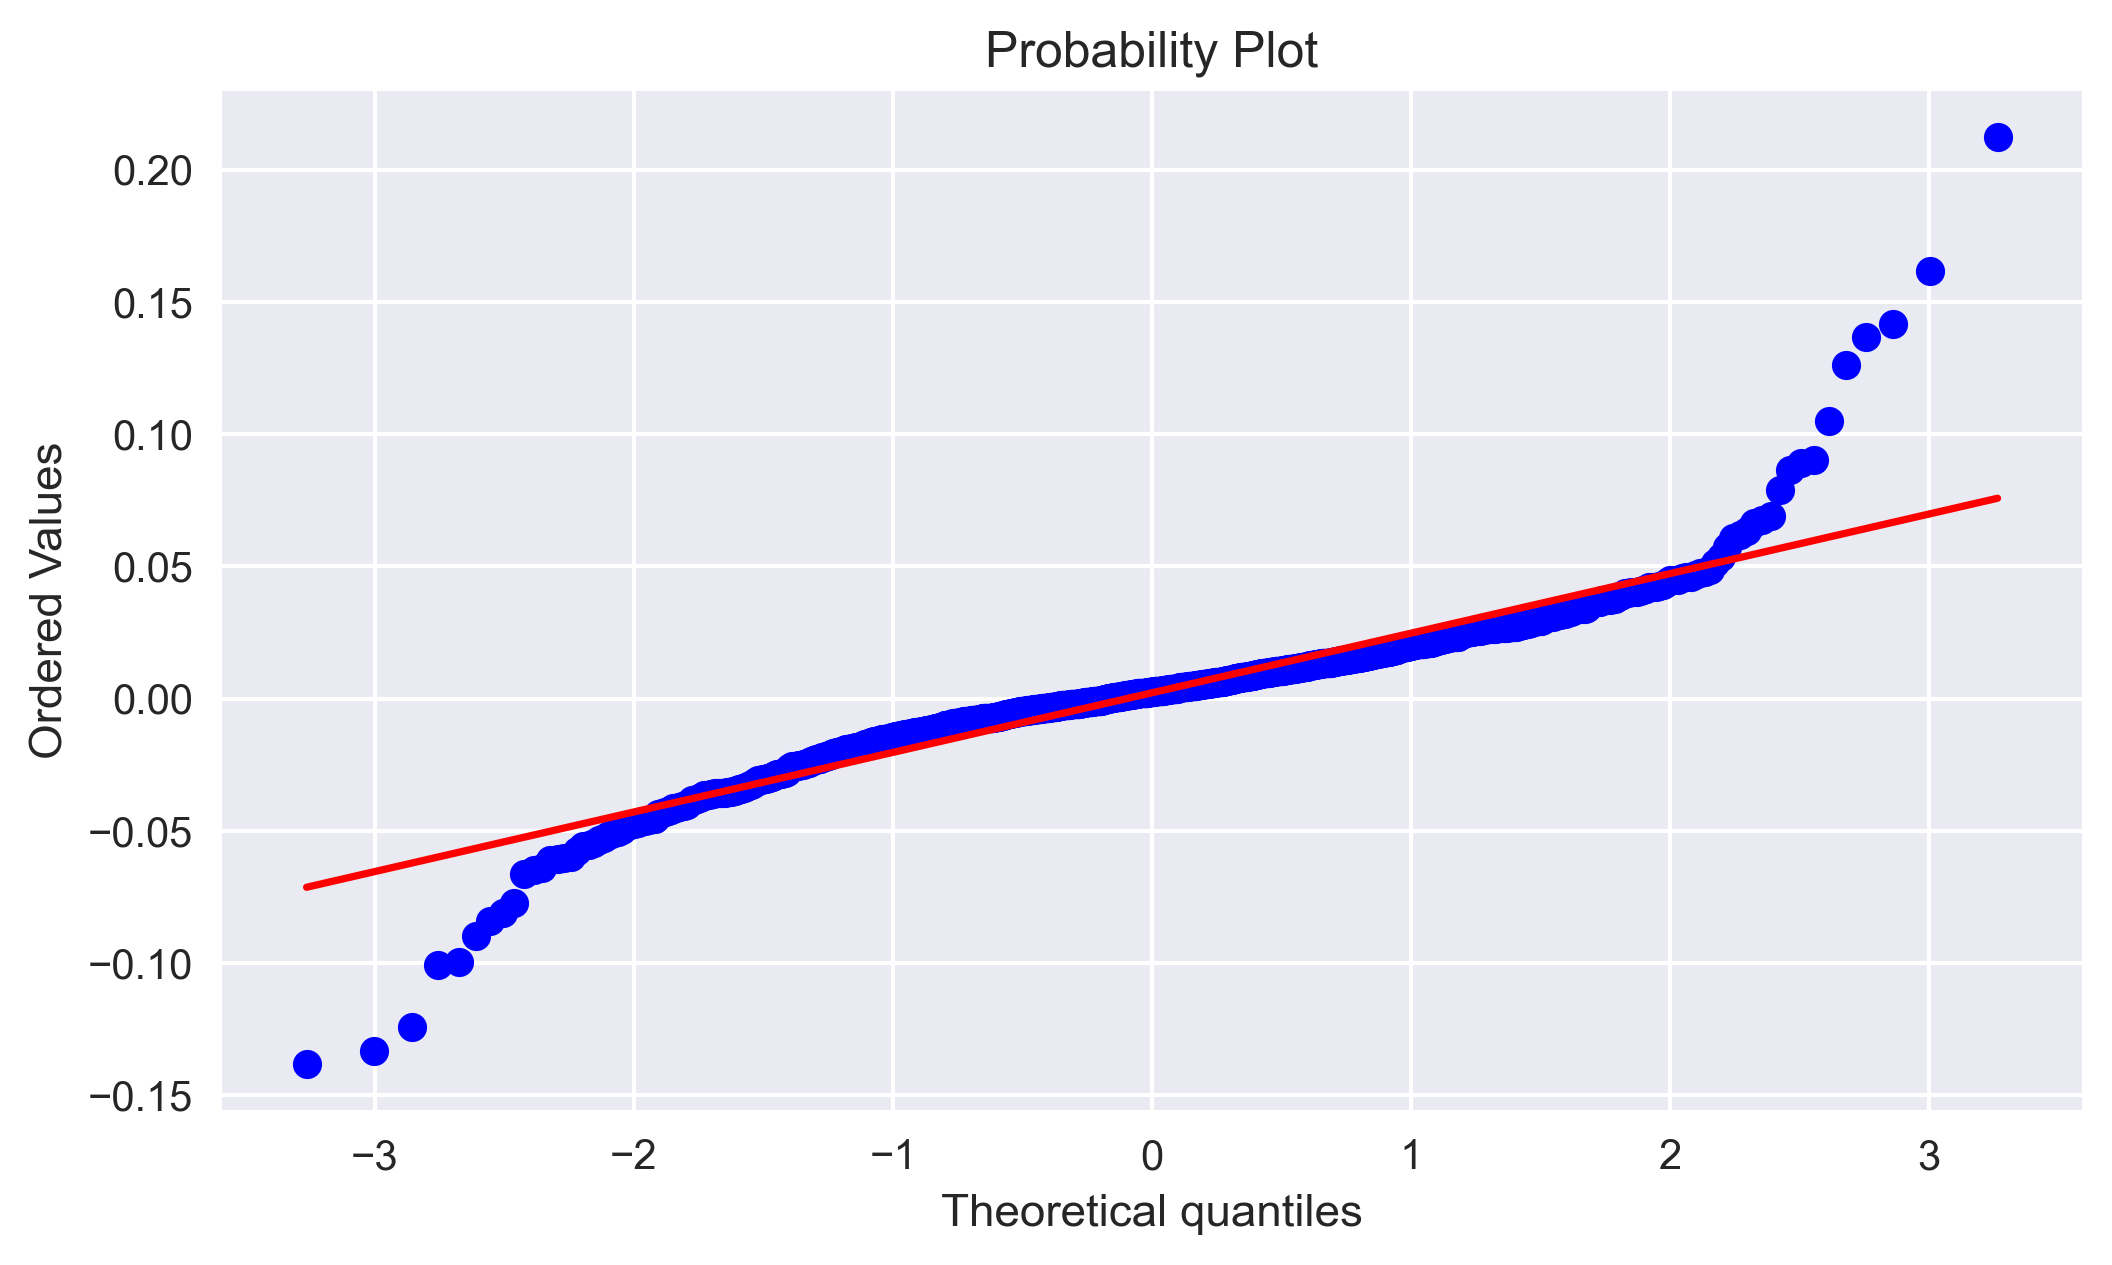

In [26]:
#Create qq plot for pct_change
import scipy.stats as stats
import pylab
stats.probplot(c, dist="norm", plot=pylab)
pylab.show()
